# GP Test Problems
An exhibition of the named GP test problems I've used.

In [1]:
def ensure_root_dir_on_path():
    import os
    import sys

    sources_root_path = os.path.abspath("../src")
    if sources_root_path not in sys.path:
        sys.path.append(sources_root_path)


ensure_root_dir_on_path()

In [2]:
import math
import os
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm

from decoupledbo.pipeline.data_catalog import DataCatalog
from decoupledbo.pipeline.main import load_and_construct_gp_test_problem
from decoupledbo.modules.pareto.sample import (
    BoTorchProblem,
    sample_points_on_pareto_front,
)

In [3]:
sns.set_theme(context="talk", style="ticks", font_scale=1.2)

In [4]:
SAVE_PLOTS = True  # If set to true, save plots when the notebook is run
PLOTS_DIR = "./plots/"

if SAVE_PLOTS and not os.path.exists(PLOTS_DIR):
    os.mkdir(PLOTS_DIR)

In [5]:
catalog = DataCatalog()

In [6]:
def plot_problem(problem, titles=None, fig=None):
    if titles is None:
        titles = [
            f"Objective {i}" for i in range(problem.num_objectives)
        ]
    
    x, y = torch.meshgrid(
        torch.linspace(0, 1, 100),
        torch.linspace(0, 1, 100),
        indexing="xy",
    )
    t = torch.stack([x, y], dim=-1)

    with torch.no_grad():
        f = problem(t, noise=False)
    
    if not fig:
        fig = plt.figure(
            figsize=(6 * problem.num_objectives, 4),
            dpi=120,
            constrained_layout=True,
        )
        
    axs = fig.subplots(1, problem.num_objectives)
    
    for i in range(problem.num_objectives):
        ax = axs[i]
        ctr = ax.contourf(x, y, f[..., i], levels=100, cmap="Oranges")
        for c in ctr.collections:
            # To reduce the size of the pdf image when saved
            c.set_rasterized(True)
        ax.contour(x, y, f[..., i], levels=10, colors="black", linewidths=1, linestyles="solid")
        fig.colorbar(ctr, ax=ax).ax.tick_params(labelsize=16)

        if titles[i]:
            ax.set_title(titles[i], fontsize=20)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    return fig

In [7]:
def sample_pareto(problem, npoints=1000):
    p_set, p_front = sample_points_on_pareto_front(BoTorchProblem(problem), npoints=npoints)
    return p_set, p_front

In [8]:
def plot_pfront(pfront, ref_point, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(6.6, 4.4), constrained_layout=True)
    
    # In order to correctly plot a disconnected pareto front, we plot using dots only.
    # The effect is that the dots form a line, and so we use a custom legend element to
    # represent the Pareto front with a black line element.
    ix = np.argsort(pfront[:, 0])
    # ax.plot(pfront[ix, 0], pfront[ix, 1], marker="o", markersize=3, drawstyle="steps-pre",  color="black", label="Pareto front")
    ax.plot(pfront[ix, 0], pfront[ix, 1], marker="o", markersize=3, linestyle="", color="black")
    pfront_legend_elt = Line2D([0], [0], color="black", label="Pareto front") 
    
    ax.axvline(ref_point[0], color="xkcd:powder blue", linestyle="--", linewidth=1, zorder=1)
    ax.axhline(ref_point[1], color="xkcd:powder blue", linestyle="--", linewidth=1, zorder=1)
    ref_point = ax.scatter([ref_point[0]], [ref_point[1]], marker="*", color="tab:blue", label="Reference point")

    ax.set_xlabel("First objective, $f_1$")
    ax.set_ylabel("Second objective, $f_2$")
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend(
        handles=[pfront_legend_elt, ref_point],
        loc="lower left",
        bbox_to_anchor=(0.,1.02, 1., 0.102),
        ncol=2,
        borderaxespad=0.,
        mode="expand",
    )
    
    return ax

## Problem family: objectives with different lengthscales
In this problem, the first objective has a shorter lengthscale than the second meaning we will need more samples to learn it. This is the problem family from figures 1a and 2a in the paper.

In [9]:
loaded_problem, hyperparams = load_and_construct_gp_test_problem(
    "lengthscales/1", catalog, noise_stds=None
)
pprint(hyperparams)

{'length_scales': [0.2, 1.8], 'means': [0, 0], 'output_scales': [1, 50]}


/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.4263], dtype=torch.float64), std = tensor([1.0270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([7.5749], dtype=torch.float64), std = tensor([1.1323], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


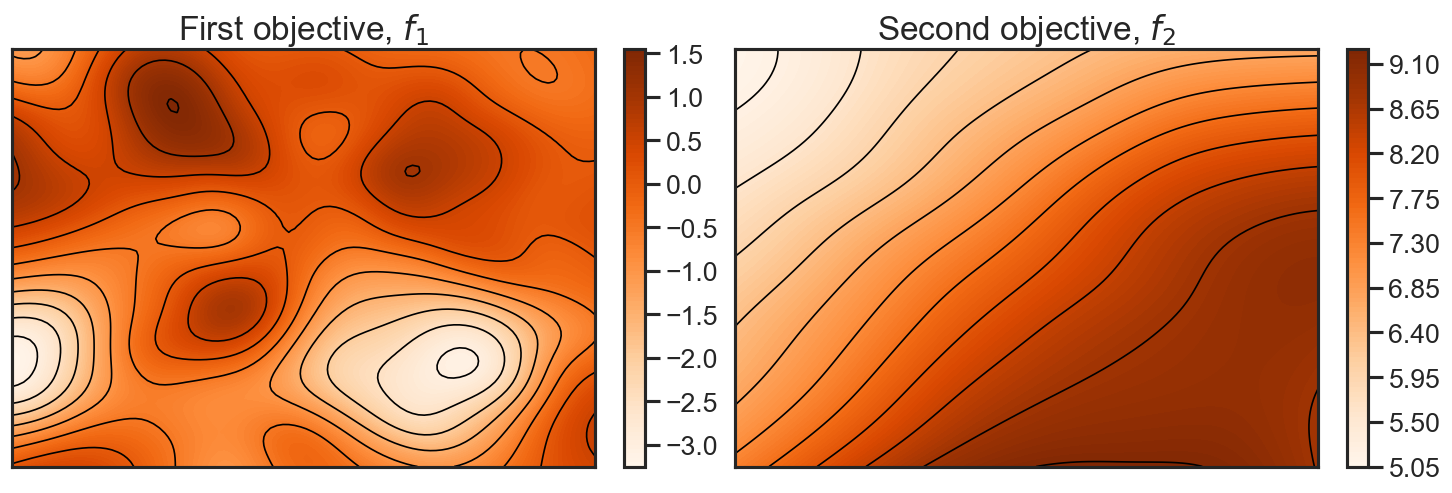

In [10]:
fig = plot_problem(
    loaded_problem,
    titles=["First objective, $f_1$", "Second objective, $f_2$"],
)

if SAVE_PLOTS:
    for ext in ["png", "pdf"]:
        fig.savefig(os.path.join(PLOTS_DIR, f"problem-lengthscales-repeat-1.{ext}"), bbox_inches="tight", dpi=200)

<timed exec>:6: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.


CPU times: user 20.6 s, sys: 609 ms, total: 21.2 s
Wall time: 8.45 s


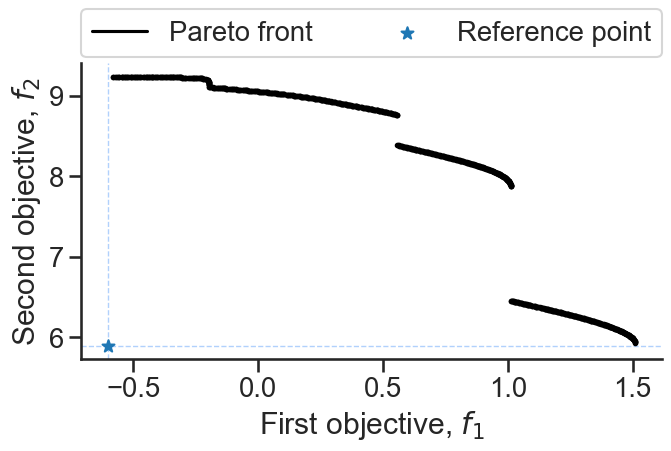

In [11]:
%%time
pset, pfront = sample_pareto(loaded_problem)
ax = plot_pfront(pfront, loaded_problem.ref_point)

if SAVE_PLOTS:
    for ext in ["png", "pdf"]:
        ax.figure.savefig(os.path.join(PLOTS_DIR, f"problem-lengthscales-repeat-1-pfront.{ext}"), bbox_inches="tight", dpi=200)

## Problem family: objectives with different observation noise
This is the problem family used for figures 1b and 2b in the paper. The fact that the experiments are run using observation noise does not affect problem generation, since we only generate and visualise the true underlying problem. This problem has a length scale of 0.4 in each objective.

In [12]:
loaded_problem, hyperparams = load_and_construct_gp_test_problem(
    "observationnoise/1", catalog, noise_stds=None
)
pprint(hyperparams)

{'length_scales': [0.4, 0.4], 'means': [0, 0], 'output_scales': [1, 1]}


/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0944], dtype=torch.float64), std = tensor([0.6661], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9064], dtype=torch.float64), std = tensor([0.4432], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


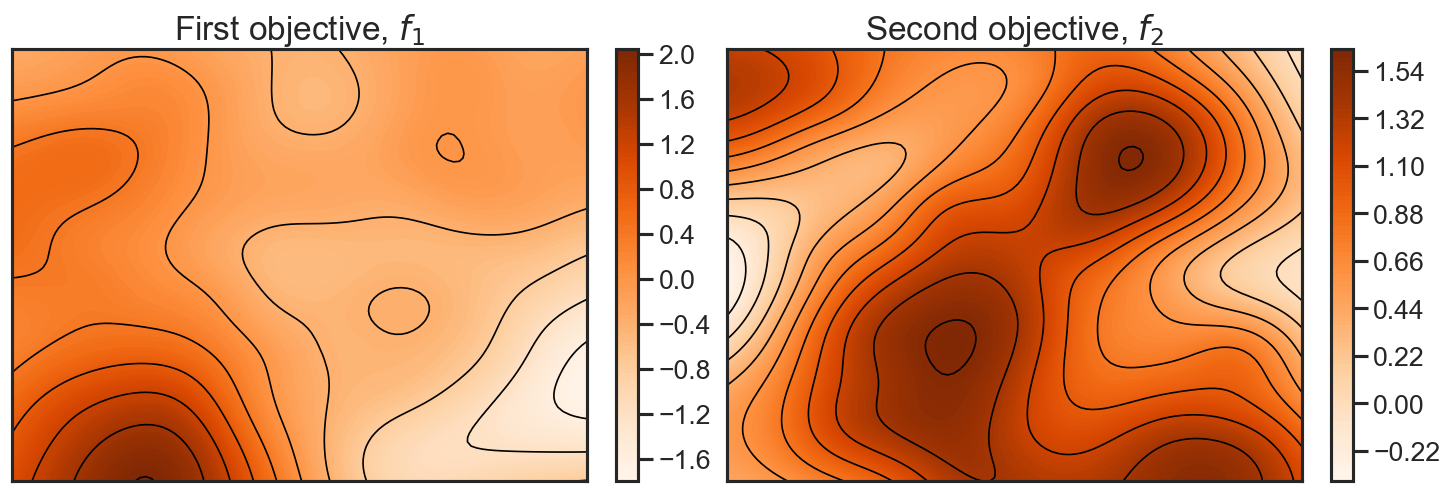

In [13]:
fig = plot_problem(
    loaded_problem,
    titles=["First objective, $f_1$", "Second objective, $f_2$"],
)

if SAVE_PLOTS:
    for ext in ["png", "pdf"]:
        fig.savefig(os.path.join(PLOTS_DIR, f"problem-observationnoise-repeat-1.{ext}"), bbox_inches="tight", dpi=200)

<timed exec>:6: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.


CPU times: user 20.3 s, sys: 574 ms, total: 20.9 s
Wall time: 8.31 s


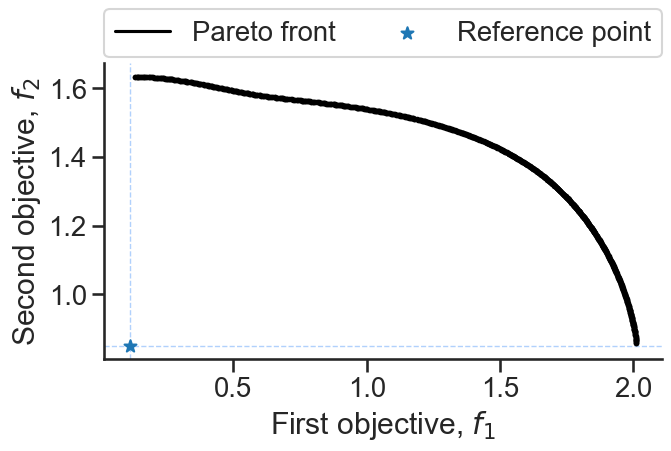

In [14]:
%%time
pset, pfront = sample_pareto(loaded_problem)
ax = plot_pfront(pfront, loaded_problem.ref_point)

if SAVE_PLOTS:
    for ext in ["png", "pdf"]:
        ax.figure.savefig(os.path.join(PLOTS_DIR, f"problem-observationnoise-repeat-1-pfront.{ext}"), bbox_inches="tight", dpi=200)